# Исследование данных об успешности игр 

В нашем распоряжении  данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Требуется спрогнозировать продажи на 2017г, руководствуясь данными 2016г. и учитывая, что данные могут быть неполными. 

Для работы с данными импортируем все необходимые библиотеки( matplotlib- для визуализации данных, numpy- для работы с многомерными массивами и математическими функциями,seaborn- для создания статистических графиков,scipy.stats-сложных вычислений, анализа данных и построения графиков,warnings- для управления предупреждениями.)

In [278]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
 
import warnings
warnings.filterwarnings('ignore')

# Шаг №1: Импортируем данные 

In [279]:
data = pd.read_csv('/datasets/games.csv')

# Шаг №2: Подготовка данных

Для ознакомления с данными таблицы, выведем на экран первые 10 строк 

In [280]:
display(data.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Также нам понадобится информация о количестве пропусков и типах данных.Выводим на экран информацию о таблице, а также о количестве пропусков и дубликатов.

Информация о данных:

In [281]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

Количество пропусков:

In [282]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Количество дубликатов:

In [283]:
data.duplicated().sum()

0

Используя полученную информацию, определим дынные и типы, которые нужно изменить:

1)В данных в столбце "namе" всего два пропуска, удалим их, так как процент пропусков незначительный. Тип указан верно. 

2)Year_of_release много пропусков (269), требуется заполнить (возможно медианным значением). Будем исследовать данные подробнее, а также заменим тип на int64, так как год реализации- это целое число.

3) Также значительное количество пропусков в данных Critic_score, User_score (изменим тип данных на float, так как в данных не указано название а тип odject). Rating требуется внимательно изучить данные и заполнить пропуска для корректного анализа, пока не ясно можно ли их заполнять как либо в целом или нужно заменить просто пустые значения на нулевые, и как корректного определить возрастной рейтинг.

4)Также есть два пропуска в столбце "Genre", удалим их, так как процент незначительный и не повлияет на исследование.

Также наименования стоблцов в таблице представлены в разном регистре, для удобства приведем их в корректный вид к нижнему регистру и обработаем названия платформ, также попробуем расшфировать аббревиатуры с рейтингом.

Приведем названия столбцов к нижнему регистру:

In [284]:
data.columns = data.columns.str.lower()


Просмотрим уникальные значение по платформам:

In [285]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Приведем названия платформ к полной версии для более комфортного визуального восприятия:

In [286]:
def replace_wrong_platforms(wrong_platforms, correct_platform):
    data['platform'] = data['platform'].replace(wrong_platforms, correct_platform)
replace_wrong_platforms('2600', 'Atari 2600')
replace_wrong_platforms('Wii', 'Nintendo Wii')
replace_wrong_platforms('NES', 'Nintendo NES')
replace_wrong_platforms('GB', 'GB-60')
replace_wrong_platforms('DS', 'Nintendo DS')
replace_wrong_platforms('X360', 'Xbox 360')
replace_wrong_platforms('SNES', 'Nintendo SNES')
replace_wrong_platforms('GBA', 'Game Boy Advance')
replace_wrong_platforms('3DS', 'Nintendo 3DS')
replace_wrong_platforms('N64', 'Nintendo 64')
replace_wrong_platforms('XB', 'Xbox')
replace_wrong_platforms('XOne', 'Xbox One')
replace_wrong_platforms('WiiU', 'Nintendo Wii U')
replace_wrong_platforms('GC', 'Nintendo GameCube')
replace_wrong_platforms('GEN', 'SEGA Retro Genesis')
replace_wrong_platforms('DC', 'Dendy Classic')
replace_wrong_platforms('PSV', 'PS Vita')
replace_wrong_platforms('SAT', 'Sega Saturn')
replace_wrong_platforms('WS', 'WonderSwan')
replace_wrong_platforms('TG16', 'NEC TurboGrafx')
replace_wrong_platforms('3DO', 'Panasonic 3DO')
replace_wrong_platforms('GG', 'Game Gear')
replace_wrong_platforms('PCFX', 'NEC PC-FX')

display(data['platform'].unique())

array(['Nintendo Wii', 'Nintendo NES', 'GB-60', 'Nintendo DS', 'Xbox 360',
       'PS3', 'PS2', 'Nintendo SNES', 'Game Boy Advance', 'PS4',
       'Nintendo 3DS', 'Nintendo 64', 'PS', 'Xbox', 'PC', 'Atari 2600',
       'PSP', 'Xbox One', 'Nintendo Wii U', 'Nintendo GameCube',
       'SEGA Retro Genesis', 'Dendy Classic', 'PS Vita', 'Sega Saturn',
       'SCD', 'WonderSwan', 'NG', 'NEC TurboGrafx', 'Panasonic 3DO',
       'Game Gear', 'NEC PC-FX'], dtype=object)

Удалим пропуска в столбце genre:

In [287]:
data.dropna(subset=['genre'], inplace=True)

Так как в данных name малый процент пропусков, удалим их:

In [288]:
data.dropna(subset=['name'], inplace=True)

Выведем все уникальные значения столбца year_of_release:

In [289]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Приведем year_of_release  в целочисленный вид для удобства обработки данных, так как год выпуска- это целое значение. Также судя по уникальным значениям, нет неккоректных данных (минусовые значения и т.д). Так как процент пропуск примерно 2%, удалим пропушенные данные.

In [290]:
data.dropna(subset=['year_of_release'], inplace=True)
data['year_of_release']=data['year_of_release'].astype(int)

In [291]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Просмотрим уникальные значения в столбце user_score:

In [292]:
display(data['user_score'].unique())

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце user_score выделим значение tbd.Формат ячейки object. Хотя судя по общему содержанию, а так же по описанию столбца тип данных должен быть float. Возможно следует считать данное значение (tbd) пустым и изменить на NaN.

Для замены значения 'tbd' на NaN будем использовать функцию:

In [293]:
def replace_wrong_user_scores(wrong_user_scores, correct_user_score):
    data['user_score'] = data['user_score'].replace(wrong_user_scores, correct_user_score)
replace_wrong_user_scores('tbd', np.NaN)

Выведем уникальные значения в столбце после применения функции:

In [294]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

Изменим тип данных на float:

In [295]:
data['user_score'] = data['user_score'].astype(float)

Заполним  user_score заглушками по платформе:

In [296]:

data.loc[data['user_score'].isna(), 'user_score'] = -1

Просмотрим уникальные значения в rating:

In [297]:
display(data['rating'].unique())

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В столбце rating есть два значения 'K-A' и 'E10+' - это два значения носящие один и тот же смысл (первоначально "K-A" ("Kids to Adults"), потом было переименовано на E10+), поэтому переименуем 'K-A' в 'E10+' для удобного и более точного анализа в дальнейшем, а также расшифруем аббревиатуры для более удобного визуального представления. Будем использовать функцию.

In [298]:
def replace_wrong_ratings(wrong_ratings, correct_rating):
    data['rating'] = data['rating'].replace(wrong_ratings, correct_rating)
replace_wrong_ratings('K-A', 'E10+')
replace_wrong_ratings('E', '6+')
replace_wrong_ratings('T', '13+')
replace_wrong_ratings('M', '17+')
replace_wrong_ratings('EC', 'E10+')
replace_wrong_ratings('E10+', '0+')
replace_wrong_ratings('RP', 'Рейтинг ожидается')
replace_wrong_ratings('AO', '18+')
data['rating'].value_counts()

6+                   3921
13+                  2905
17+                  1536
0+                   1404
18+                     1
Рейтинг ожидается       1
Name: rating, dtype: int64

Присвоим пропущенным данным название "неопределен", т.к. мы не сможем понять возрастное ограничение, если не будем знать это точно, а количество пропусков слишком большое и удаление повлияет на анализ.

In [299]:
def replace_wrong_user_scores(wrong_user_scores, correct_user_score):
    data['rating'] = data['rating'].replace(wrong_user_scores, correct_user_score)
replace_wrong_user_scores(np.NaN, 'неопределен')

Заменим заглушками пропуска в critic_score, так как пропуски могут повлиять на дальнейшую аналитику и составляют достаточный процент от данных, удалить их нельзя. Причиной отсутствия оценки критиков, может быть просто отсутствие информации (неоцененные игры) или же игры были недавнего вышедшие и еще не получили свои оценки:

In [300]:
data.loc[data['critic_score'].isna(), 'critic_score'] = -1

Проверяем количество пропусков после обработки:

In [301]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Необходимо посчитать сумму продаж во всех регионах. Для этого суммируем значения нескольких столбцов (na_sales, eu_sales, jp_sales, other_sales) и полученные значения присвоить столбцу total_sales.

Рассчитываем суммарные продажи по регионам:

In [302]:
data_all=data# Таблица для будующих рассчетов, перед изменением данных
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Выводим первые 10 строк новой таблицы:

In [303]:
data.head(10)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Nintendo Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,6+,82.54
1,Super Mario Bros.,Nintendo NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,неопределен,40.24
2,Mario Kart Wii,Nintendo Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,6+,35.52
3,Wii Sports Resort,Nintendo Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,6+,32.77
4,Pokemon Red/Pokemon Blue,GB-60,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,неопределен,31.38
5,Tetris,GB-60,1989,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,неопределен,30.26
6,New Super Mario Bros.,Nintendo DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,6+,29.80
7,Wii Play,Nintendo Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,6+,28.91
8,New Super Mario Bros. Wii,Nintendo Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,6+,28.32
9,Duck Hunt,Nintendo NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,неопределен,28.31


# Шаг №3: Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы и определим важность полученных данных.

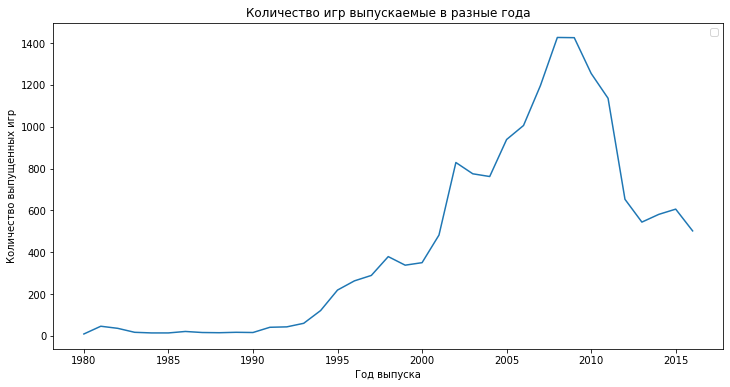

In [304]:
games_on_period = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=games_on_period)
plt.title("Количество игр выпускаемые в разные года")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')

Вывод: 
Из графика видно, что количество выпущенных игр начало  расти с большой скоростью с 1998 годов до 2008 года. 
С 2008 года, возможно начали набирать популярность мобильные приложения и мобильные игры, из-за чего и произошел резкий спад для игр на консоли.

Посчитаем сумму игр в группировке по игровой платформе и годам за весь период.

In [305]:
data.groupby(['platform', 'year_of_release'])['name'].count()

platform    year_of_release
Atari 2600  1980                9
            1981               46
            1982               36
            1983               11
            1984                1
                               ..
Xbox 360    2016               13
Xbox One    2013               19
            2014               61
            2015               80
            2016               87
Name: name, Length: 238, dtype: int64

А также общее количество игр по годам.

In [306]:
data.groupby('year_of_release')['name'].count().sort_values(ascending=False)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: name, dtype: int64

Посмотрим общее количество продаж по платформам:

,total_sales
platform,
PS2,1233.56
Xbox 360,961.24
PS3,931.34
Nintendo Wii,891.18
Nintendo DS,802.78
PS,727.58
PS4,314.14
Game Boy Advance,312.88
PSP,289.53


Text(0, 0.5, 'Количество продаж')

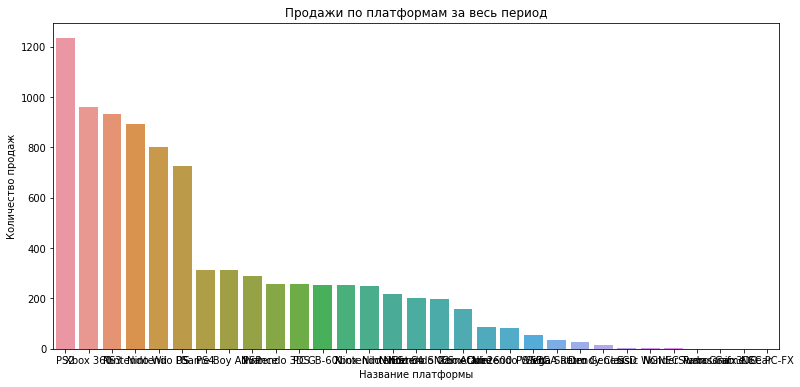

In [307]:
platform_on_sales = data_all.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
display(platform_on_sales)
plt.figure(figsize=(13,6))
sns.barplot(x=platform_on_sales.index,y=platform_on_sales['total_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")

Вывод: за весь период лидирующие платформы по сумарным продажам-PS2, Xbox, PS3, Nintendo Wii, Nintendo DS.

Построим график количества продаж платформ по годам:

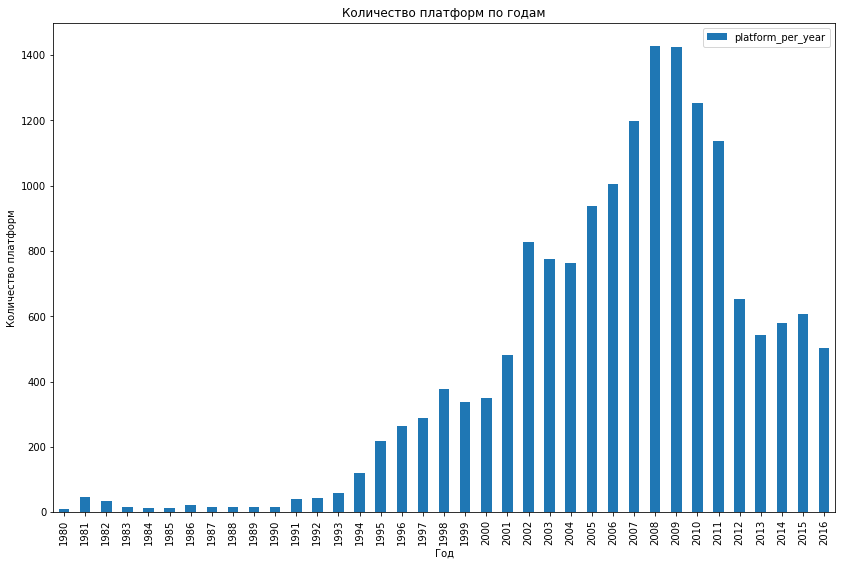

In [308]:
platform_on_sales = data_all.pivot_table(
    index='year_of_release',  values='platform', aggfunc='count')
platform_on_sales 
platform_on_sales.columns = ['platform_per_year']
platform_on_sales.plot(kind='bar', 
                              y='platform_per_year', 
                              figsize=(14, 9), 
                              title='Количество платформ по годам')
plt.xlabel('Год')
plt.ylabel('Количество платформ')
plt.show()

Вывод: Быстрой рост продаж платформ начался в 2000х и пошел на спад после 2010 года.

График распределения самых популярных платформ:

,total_sales
platform,
PS2,1233.56
Xbox 360,961.24
PS3,931.34
Nintendo Wii,891.18
Nintendo DS,802.78
PS,727.58


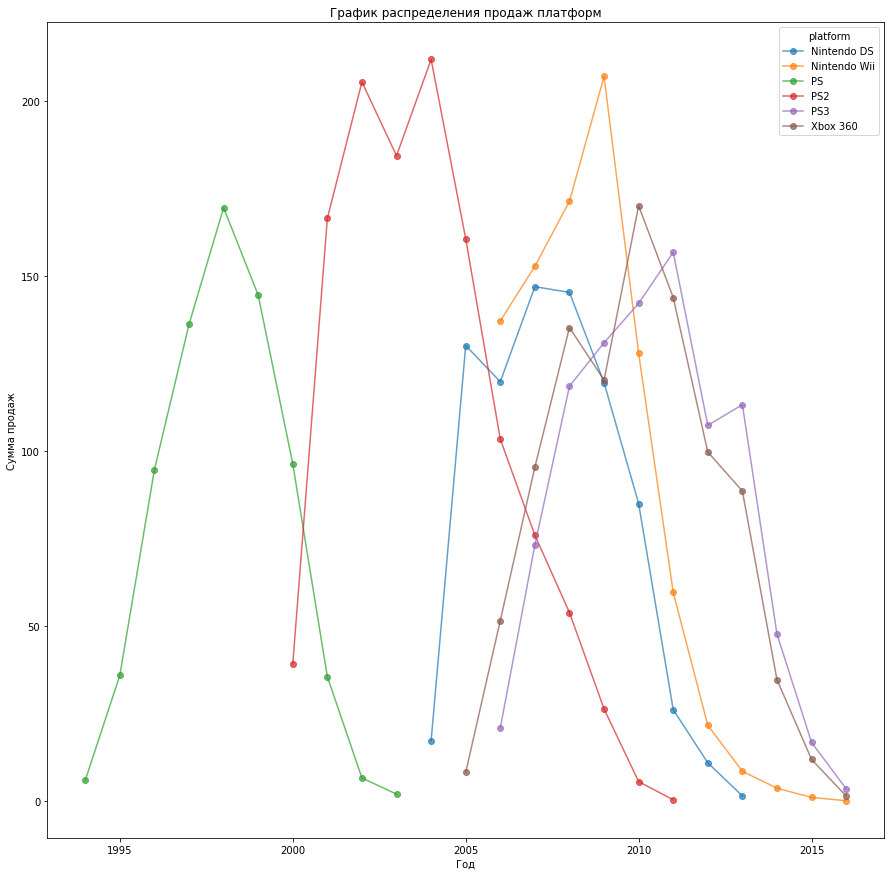

In [309]:
popular_platform = data_all.pivot_table(index='platform',
                     values='total_sales', 
                     aggfunc='sum').sort_values('total_sales', ascending=False).head(6)
display(popular_platform)

most_popular_platforms_per_year = (
    data_all.query('platform in @popular_platform.index and year_of_release > 1985')
    .pivot_table(index='year_of_release',
                 columns='platform',
                 values='total_sales',
                 aggfunc='sum')
)
def most_popular_plot(data, figsize):
    
    data.plot(
        style='o-', 
        figsize=figsize, 
        title='График распределения продаж платформ', 
        alpha=.7)

    plt.xlabel('Год')
    plt.ylabel('Сумма продаж')
    plt.show()
most_popular_plot(most_popular_platforms_per_year, (15, 15))

Вывод:
- Практически все игровые платформы в среднем существуют от 8 до 10 лет. 
- Cамые продаваемые: PS2 и Xbox360.
- Самый пик наступает примерно через 3-5 лет после выхода приставки.
- у Nintento WII был быстрый скачок в 2009 году и такой же резкий провал.

2015-2106гг.-будут оптимальными для анализа динамики продаж. Посторим график распределения по суммарным продажам в выбранном отрезке врмени и платформам.

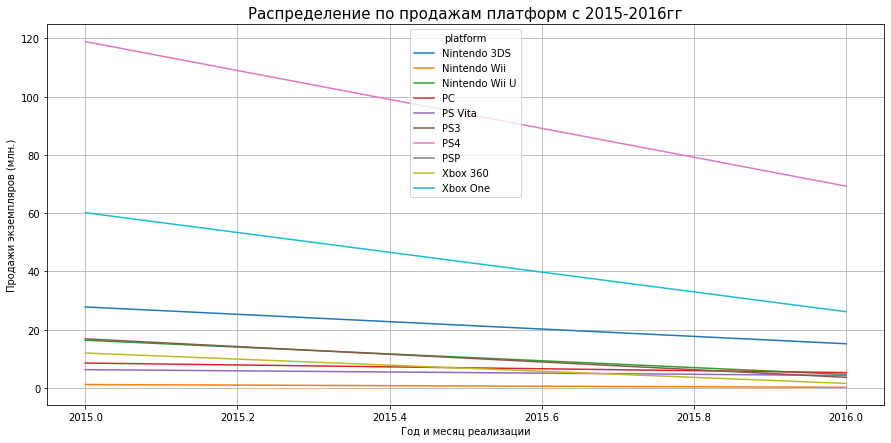

In [310]:
data_period = data.query("2015 <= year_of_release <= 2016")
data_period.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7))
plt.title('Распределение по продажам платформ с 2015-2016гг', fontsize=15)
plt.xlabel('Год и месяц реализации')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Из графика видно, что топ-3 популярных игровых платформ за период с 2015-2016гг - это PS4, Xbox One, Nintendo 3DS. В основном заметен спад продаж по всем платфорам.

Выведем суммы продаж по платформам на экран, отсортируем от большего к меньшему и выберем топ платформ по суммарным продажам:

In [311]:
data.groupby(['platform'])['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'].sum().sort_values(by='total_sales',ascending=False)

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS2,572.92,332.63,137.54,190.47,1233.56
Xbox 360,595.74,268.32,12.30,84.88,961.24
PS3,390.13,327.21,79.41,134.59,931.34
Nintendo Wii,486.87,258.32,68.28,77.71,891.18
Nintendo DS,380.31,188.41,175.02,59.04,802.78
PS,334.72,212.39,139.78,40.69,727.58
PS4,108.74,141.09,15.96,48.35,314.14
Game Boy Advance,184.12,74.59,46.56,7.61,312.88
PSP,107.27,65.62,75.88,40.76,289.53


Топ-3 платформы по суммарным продажам- PS4, Xbox One, Nintendo 3DS. По остальным продажи значительно меньше.

Оставим только интересующие нас платформы из предыдущего шага и построем графики распределения для них в актуальный период.

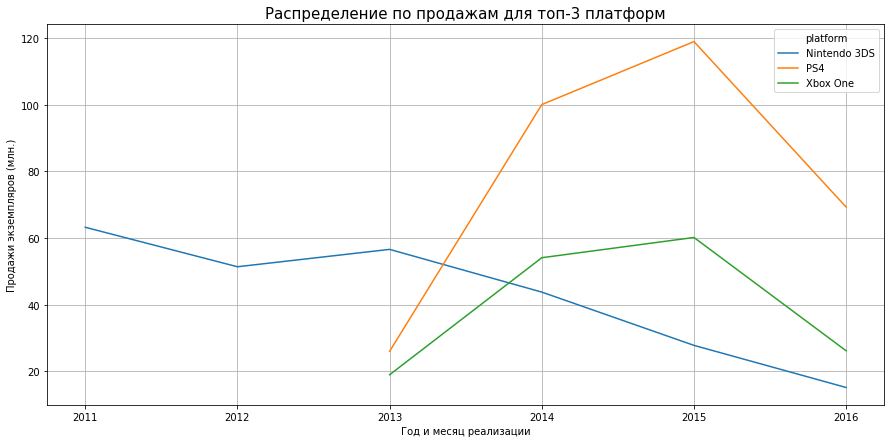

In [312]:
data = data.query("platform == ['Xbox One', 'PS4','Nintendo 3DS']")
data.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7))
plt.title('Распределение по продажам для топ-3 платформ', fontsize=15)
plt.xlabel('Год и месяц реализации')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Самой прибыльная платформа PS4, падение продаж, судя по графику, не такое значительное как у Xbox One(хотя она тоже держится на плаву пусть и менее уверено). Nintendo 3DS на последнем месте, но за счет итак небольших продаж, падение кажется не столь значительным как у остальных.

Выводы, которые мы можем сделать из полученной информации: 
- Cамые продаваемые:PS4 и Xbox One, также можно учитывать Nintendo 3DS;
- В период с 2015-2016 гг даже самые популярные платформы падают по продажам.

Построение графика «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

Создадим график "ящик с усами" для пяти самых популярных игровых платформ:

Text(0, 0.5, 'Глобальные продажи')

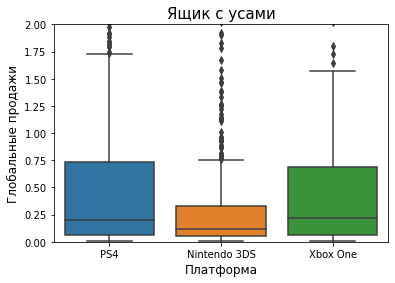

In [313]:

sns.boxplot(data=data, x='platform', y='total_sales')
plt.ylim(0,2)
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)


Вывод:
Самой прибыльной платформой получается Xbox One (почему так получается, непонятно.... Возможно, я не так указала данные, но не понимаю, где ошибка...S0S нужна помощь SOS)

Исследуем влияние на продажи отзывов пользователей и критиков внутри одной популярной платформы. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Рассчитаем корреляцию между оценками пользователей и суммарными продажами для самой популярной по исследованию платформе PS4:

Убираем заглушки:

Рассчитываем корреляцию для отзывов пользователей:

In [314]:
ps= data_period[data_period['platform']=='PS4']#фильтруем по платформе
data_ps = ps[ps['user_score'] != -1]#по платформе и заглушкам
print('Корреляция между отзывами пользователей и продажами для PS4:', data_ps['user_score'].corr(data_ps['total_sales']))

Корреляция между отзывами пользователей и продажами для PS4: -0.05973845712638215


Построим диаграмму рассеивания:

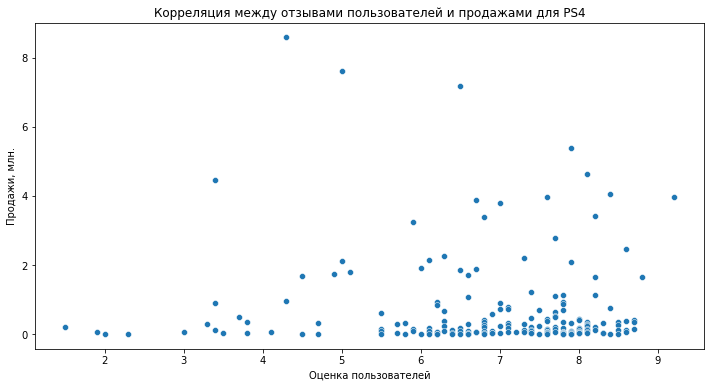

In [315]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=data_ps)
plt.title('Корреляция между отзывами пользователей и продажами для PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн.')
plt.show()

Вывод: Корреляция слабоотрицательная.

Корреляция по отзывам критиков:

In [316]:
ps = data_period[data_period['platform']=='PS4']#фильтруем по платформе
data_ps_critic = ps[ps['critic_score'] != -1]#по платформе и заглушкам
print('Корреляция между отзывами критиков и продажами для PS4:', data_ps_critic['critic_score'].corr(data_ps_critic['total_sales']))

Корреляция между отзывами критиков и продажами для PS4: 0.3928485555130601


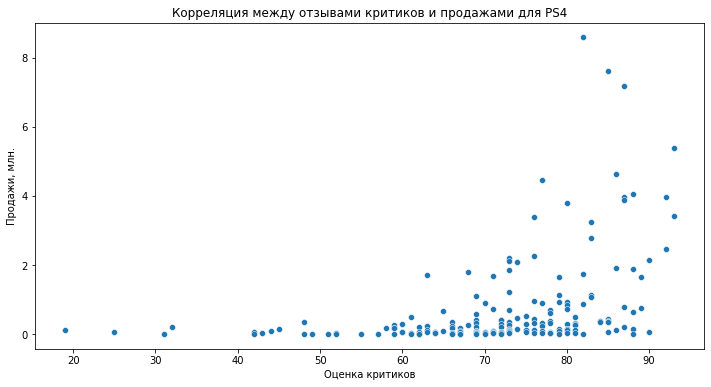

In [317]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=data_ps_critic)
plt.title('Корреляция между отзывами критиков и продажами для PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн.')
plt.show()

Вывод: корреляция между оценкой критиков выше, чем между оценкой пользователей. Для критиков умеренно положительная, для пользователей отрицательная.

Проведем данное исследование для оставшихся 2 популярных платформ.

Корреляция между отзывами пользователей и продажами для Xbox One: -0.04146733387366271


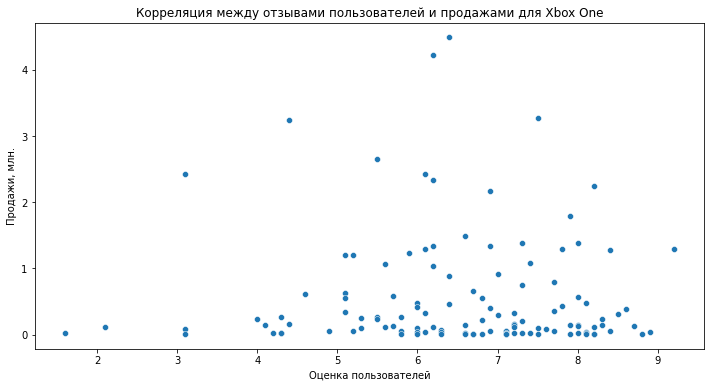

Корреляция между отзывами критиков и продажами для Xbox One: 0.43088874582136805


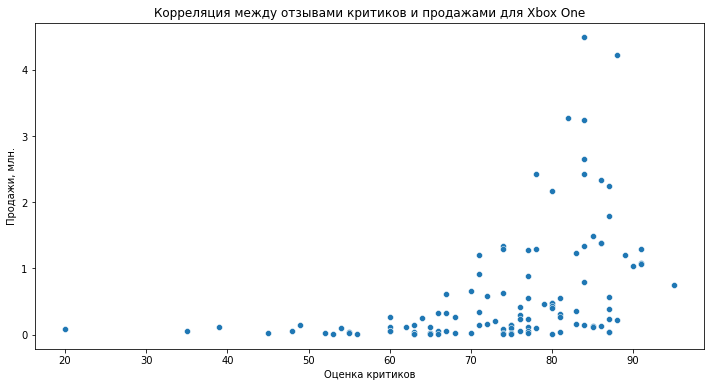

In [318]:
x_box = data_period[data_period['platform']=='Xbox One']
data_xb=x_box[x_box['user_score'] != -1]
print('Корреляция между отзывами пользователей и продажами для Xbox One:', data_xb['user_score'].corr(data_xb['total_sales']))
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=data_xb)
plt.title('Корреляция между отзывами пользователей и продажами для Xbox One')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн.')
plt.show()

x_box = data_period[data_period['platform']=='Xbox One']
data_xb_critic=x_box[x_box['critic_score'] != -1]
print('Корреляция между отзывами критиков и продажами для Xbox One:', data_xb_critic['critic_score'].corr(data_xb_critic['total_sales']))
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=data_xb_critic)
plt.title('Корреляция между отзывами критиков и продажами для Xbox One')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн.')
plt.show()

Вывод: корреляция между оценкой критиков выше, чем между оценкой пользователей. В первом случае умеренно положительная, во втором слабоотрицательная.

Корреляция между отзывами пользователей и продажами для Nintendo 3DS: 0.19879627008102982


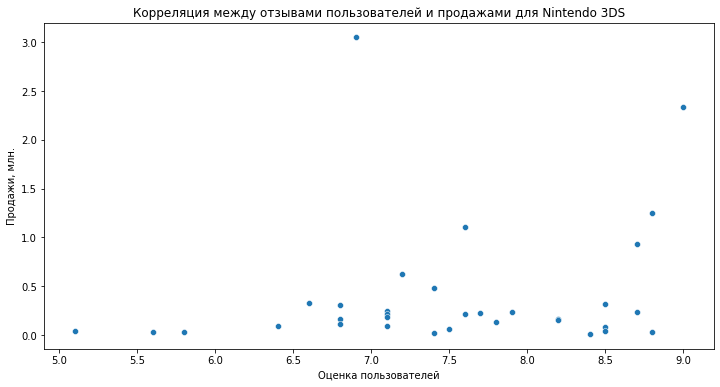

Корреляция между отзывами критиков и продажами для Nintendo 3DS: 0.17757455046092874


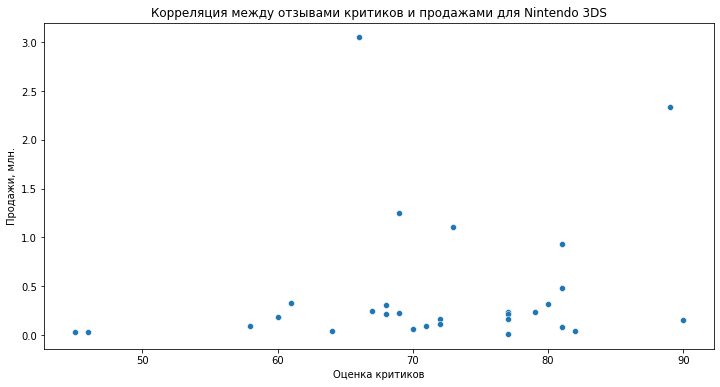

In [319]:
nd = data_period[data_period['platform']=='Nintendo 3DS']
data_nd=nd[nd['user_score'] != -1]
print('Корреляция между отзывами пользователей и продажами для Nintendo 3DS:', data_nd['user_score'].corr(data_nd['total_sales']))
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=data_nd)
plt.title('Корреляция между отзывами пользователей и продажами для Nintendo 3DS')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн.')
plt.show()

nd = data_period[data_period['platform']=='Nintendo 3DS']
data_nd_critic=nd[nd['critic_score'] != -1]

print('Корреляция между отзывами критиков и продажами для Nintendo 3DS:', data_nd_critic['critic_score'].corr(data_nd_critic['total_sales']))
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=data_nd_critic)
plt.title('Корреляция между отзывами критиков и продажами для Nintendo 3DS')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн.')
plt.show()

Корреляция слабая в двух случаях, но мнение пользователей играет большую роль, чем критиков.

Вывод: 
- Практически у всех платформ присутствуем корреляция, между оценками пользователей и критиков к продажам, в основном слабая;
- Оценка пользователей слабо влияет на продажи, чего не скажешь о оценке критиков. Для Nintendo 3DS ситуация обратная.
- Покупатели полагаются на мнение критиков больше, чем на оценки других пользователей.

Исследуем общее распределение игр по жанрам и выясним какие жанры наиболее прибыльные. 

Посторим график по жанрам и продажам и отсортируем их по убыванию:

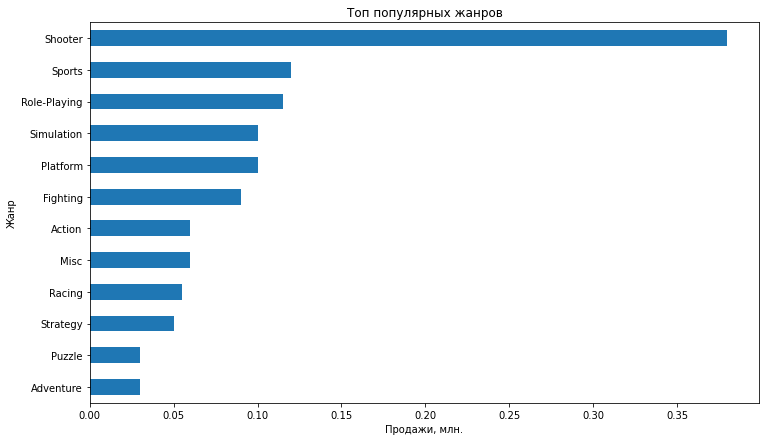

In [320]:
data_period.groupby('genre').agg('median')['total_sales'].sort_values().plot(kind='barh', y='name', legend=False, figsize=(12, 7))
plt.title('Топ популярных жанров')
plt.xlabel('Продажи, млн.')
plt.ylabel('Жанр')
plt.show()


Вывод: 
- Топ-3 популярных жанров по продажам: Shooter, Role-playing, Sports;
- Самый не популярный жанр Puzzle и Advanture.

Общий вывод по исследованию:
1) Пик выпуска игр для приставок приходится на период с1995-2008гг.

2) Спад реализации игр с 2008г, возможно связан с выпуском мобильных игр.

3) Практически все игровые платформы в среднем существуют от 8 до 10 лет.

4) Cамые продаваемые за весь период: PS2 и Xbox360.

5) Пик продаж наступает примерно через 3-5 лет после выхода приставки.

6) У Nintento WII был быстрый скачок в 2009 году и такой же резкий провал.

7) Топ-3 игровых платформ:PS4, Xbox One,Nintendo 3DS.

8) На протяжении 2015-2016гг идет спад продаж платформ, стабильнее всего держится PS4.

9) Больше всего продаются игры продаются в жанре Shooter, Spots,Role-playing.

10) У всех платформ наблюдается взаимосвязь между продажами и оценками критиков и пользователей. 

11) Заметнее всего корреляция между оценками критиков и продажами. Это значит для людей мнение критиков важнее мнения других пользователей.

# Портрет пользователя каждого региона

### Топ-5 для Северной Америки

Топ популярных платформ для Северной Америки за весь период :

,platform,na_sales
0,Xbox 360,595.74
1,PS2,572.92
2,Nintendo Wii,486.87
3,PS3,390.13
4,Nintendo DS,380.31


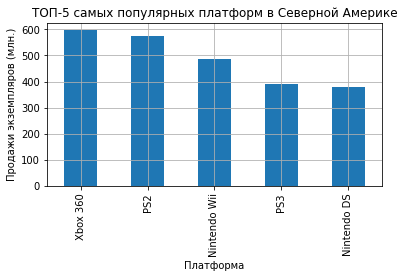

In [342]:
top_platform_na = data_all.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_platform_na= top_platform_na.reset_index().rename_axis(None, axis=1)
display(top_platform_na)
platform_na = data_all.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
platform_na.plot(x = 'platform', y = 'na_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных платформ в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ популярных жанров для Северной Америки за весь период:

,genre,na_sales
0,Action,863.17
1,Sports,671.20
2,Shooter,584.83
3,Platform,444.44
4,Misc,399.57


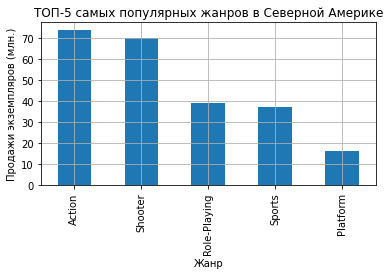

In [343]:
top_genre_na = data_all.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_genre_na= top_genre_na.reset_index().rename_axis(None, axis=1)
display(top_genre_na)
top_genre_na = data.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
top_genre_na.plot(x = 'genre', y = 'na_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных жанров в Северной Америке')
plt.xlabel('Жанр')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по рейтингу для Северной Америки за весь период:

,rating,na_sales
0,6+,1274.24
1,неопределен,1225.84
2,13+,747.60
3,17+,742.89
4,0+,349.59


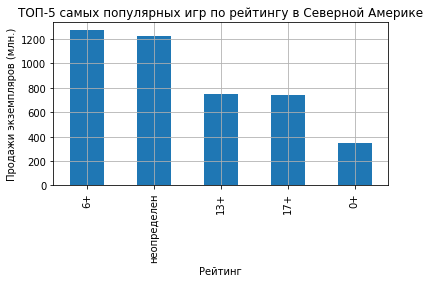

In [344]:
top_rating_na = data_all.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_rating_na= top_rating_na.reset_index().rename_axis(None, axis=1)
display(top_rating_na)
top_rating_na = data_all.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head(5)

top_rating_na.plot(x = 'rating', y = 'na_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных игр по рейтингу в Северной Америке')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по платформам с 2015г. для Северной Америки:

,platform,na_sales
0,PS4,63.86
1,Xbox One,50.30
2,Nintendo 3DS,10.31
3,Nintendo Wii U,8.86
4,Xbox 360,8.05


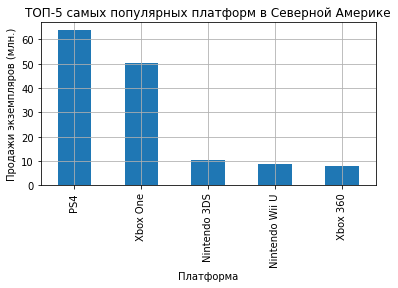

In [345]:

top_platform_na = data_period.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_platform_na= top_platform_na.reset_index().rename_axis(None, axis=1)
display(top_platform_na)

platform_na = data_period.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
platform_na.plot(x = 'platform', y = 'na_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных платформ в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по жанрам с 2015г. для Северной Америки:

,genre,na_sales
0,Shooter,48.18
1,Action,33.68
2,Sports,26.31
3,Role-Playing,19.82
4,Misc,5.58


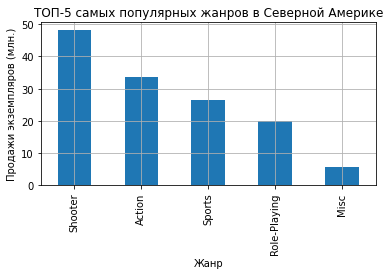

In [346]:
top_genre_na = data_period.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_genre_na= top_genre_na.reset_index().rename_axis(None, axis=1)
display(top_genre_na)
top_genre_na = data_period.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)

top_genre_na.plot(x = 'genre', y = 'na_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных жанров в Северной Америке')
plt.xlabel('Жанр')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по рейтингу с 2015г. для Северной Америки:

,rating,na_sales
0,17+,47.03
1,неопределен,37.44
2,6+,26.59
3,13+,22.86
4,0+,17.87


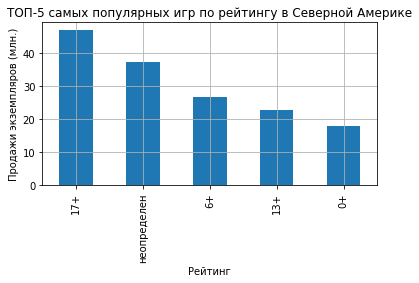

In [347]:
top_rating_na = data_period.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_rating_na= top_rating_na.reset_index().rename_axis(None, axis=1)
display(top_rating_na)
top_rating_na = data_period.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head(5)
top_rating_na.plot(x = 'rating', y = 'na_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных игр по рейтингу в Северной Америке')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Вывод: 
- Самые популярные игровые платформы в Северной Америке за все время: Xbox 360, PS2, Nintendo Wii, PS3, Nintendo DS;
- Топ-5 жанров в Северной америке за все время: action, sports, shooter, platform, misc;
- По рейтингам видно, что больше всего продаж за все время у игр с рейтингом "+6", на втором месте игры с неопределенным (данных нет) рейтингом и на третьем месте игры с рейтингом "+13".

Если посмотреть с 2015 по 2016 года, то мы видим как интерес кардинально меняется:
- Топ-3 игровых приставок выглядит таким образом :PS4, Xbox One, Nintendo Wii U;
- Топ-3 жанров игр: Shooter, Action, Sports, сопоставим в целом с результатми за весь период, но shooter вышли на первое место;
- Топ-3 рейтингов игр : "+17" , "+13" и "+6", взрослых стало играть в игры больше, при условии, что при покупке соблюден возрастной ценз.

### Топ-5 для Европы

Топ популярных платформ для Европы за весь период:

,platform,eu_sales
0,PS2,332.63
1,PS3,327.21
2,Xbox 360,268.32
3,Nintendo Wii,258.32
4,PS,212.39


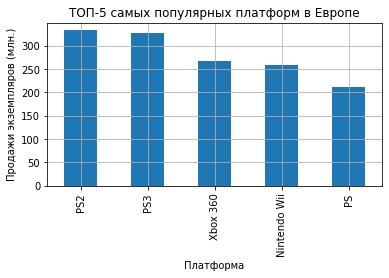

In [348]:
top_platform_eu = data_all.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_platform_eu= top_platform_eu.reset_index().rename_axis(None, axis=1)
display(top_platform_eu)
platform_eu = data_all.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
platform_eu.plot(x = 'platform', y = 'eu_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных платформ в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ популярных жанров для Европы за весь период:

,genre,eu_sales
0,Action,510.99
1,Sports,371.33
2,Shooter,314.52
3,Racing,234.49
4,Misc,210.60


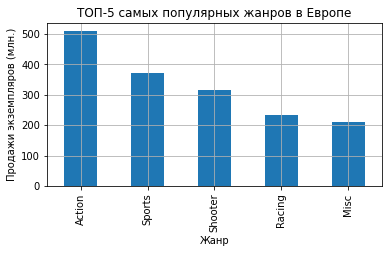

In [349]:
top_genre_eu = data_all.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_genre_eu= top_genre_eu.reset_index().rename_axis(None, axis=1)
display(top_genre_eu)
top_genre_eu = data_all.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_genre_eu.plot(x = 'genre', y = 'eu_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных жанров в Европе')
plt.xlabel('Жанр')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по рейтингу для Европы за весь период:

,rating,eu_sales
0,6+,703.87
1,неопределен,609.65
2,17+,480.00
3,13+,421.79
4,0+,183.73


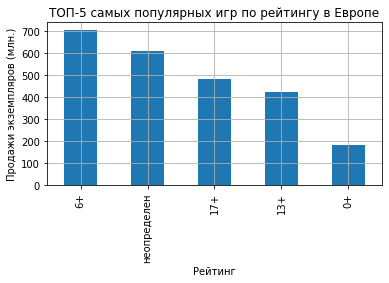

In [350]:
top_rating_eu = data_all.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_rating_eu= top_rating_eu.reset_index().rename_axis(None, axis=1)
display(top_rating_eu)
top_rating_eu = data_all.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head(5)

top_rating_eu.plot(x = 'rating', y = 'eu_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных игр по рейтингу в Европе')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по платформам с 2015г. в Европе:

,platform,eu_sales
0,PS4,83.54
1,Xbox One,28.10
2,PC,9.10
3,Nintendo 3DS,7.39
4,PS3,7.30


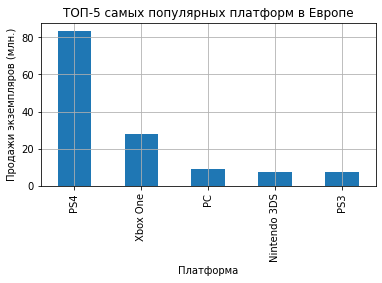

In [351]:

top_platform_eu = data_period.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_platform_eu= top_platform_eu.reset_index().rename_axis(None, axis=1)
display(top_platform_eu)

platform_eu = data_period.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
platform_eu.plot(x = 'platform', y = 'eu_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных платформ в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по жанрам с 2015г. в Европе:

,genre,eu_sales
0,Shooter,40.28
1,Action,34.82
2,Sports,27.82
3,Role-Playing,17.21
4,Racing,6.52


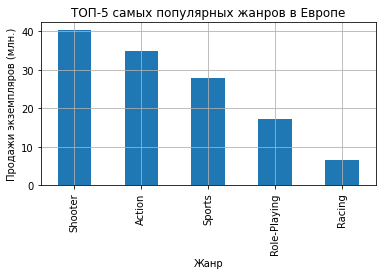

In [352]:
top_genre_eu = data_period.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_genre_eu= top_genre_eu.reset_index().rename_axis(None, axis=1)
display(top_genre_eu)
top_genre_eu = data_period.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)

top_genre_eu.plot(x = 'genre', y = 'eu_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных жанров в Европе')
plt.xlabel('Жанр')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по рейтингу с 2015г. в Европе:

,rating,eu_sales
0,17+,45.54
1,неопределен,35.71
2,6+,34.83
3,13+,20.32
4,0+,11.54


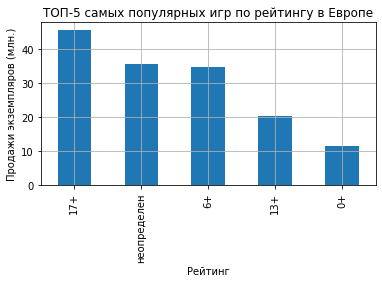

In [353]:
top_rating_eu = data_period.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_rating_eu= top_rating_eu.reset_index().rename_axis(None, axis=1)
display(top_rating_eu)
top_rating_eu = data_period.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_rating_eu.plot(x = 'rating', y = 'eu_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных игр по рейтингу в Европе')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Вывод:
- Самые популярные игровые платформы в Европе это: PS2, PS3, Xbox 360, Nintendo WII, PS;
- Топ-5 жанров в Европе : action, sports, shooter, racing, misc;
- По рейтингам видно, что больше всего продаж у игр с рейтингом "+6", на втором месте игры с рейтингом "неопределн" и на третьем месте игры с рейтингом "+17".

За последний год интерес у пользователя несколько изменился:
- Топ жанров стал: shooter, sports, action;
- Топ платформ: PS4, Xbox One, PC;
- Топ рейтингов: "+17" , "+6" и "+13".

### Топ-5 для Японии

Топ популярных платформ для Японии за весь период:

,platform,jp_sales
0,Nintendo DS,175.02
1,PS,139.78
2,PS2,137.54
3,Nintendo SNES,116.55
4,Nintendo 3DS,100.62


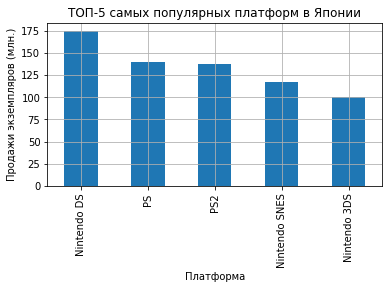

In [354]:
top_platform_jp = data_all.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_platform_jp= top_platform_jp.reset_index().rename_axis(None, axis=1)
display(top_platform_jp)
platform_jp = data_all.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)
platform_jp.plot(x = 'platform', y = 'jp_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных платформ в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ популярных жанров в Японии за весь период:

,genre,jp_sales
0,Role-Playing,353.39
1,Action,160.14
2,Sports,134.93
3,Platform,130.71
4,Misc,107.02


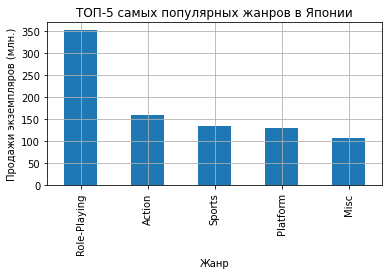

In [355]:
top_genre_jp = data_all.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_genre_jp= top_genre_jp.reset_index().rename_axis(None, axis=1)
display(top_genre_jp)
top_genre_jp = data_all.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)
top_genre_jp.plot(x = 'genre', y = 'jp_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных жанров в Японии')
plt.xlabel('Жанр')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по рейтингу в Японии за весь период:

,rating,jp_sales
0,неопределен,836.74
1,6+,197.96
2,13+,150.70
3,17+,63.58
4,0+,41.66


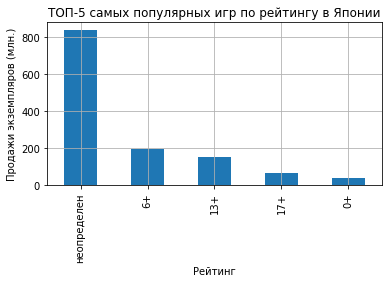

In [356]:
top_rating_jp = data_all.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_rating_jp= top_rating_jp.reset_index().rename_axis(None, axis=1)
display(top_rating_jp)
top_rating_jp = data_all.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head(5)

top_rating_jp.plot(x = 'rating', y = 'jp_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных игр по рейтингу в Японии')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по платформам с 2015г. в Японии:

,platform,jp_sales
0,Nintendo 3DS,23.55
1,PS4,12.05
2,PS Vita,8.41
3,PS3,4.97
4,Nintendo Wii U,4.12


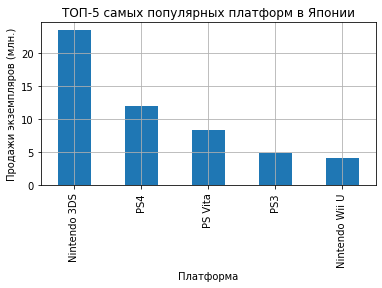

In [357]:
top_platform_jp = data_period.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_platform_jp= top_platform_jp.reset_index().rename_axis(None, axis=1)
display(top_platform_jp)

platform_jp = data_period.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)
platform_jp.plot(x = 'platform', y = 'jp_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных платформ в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по жанрам с 2015г. в Японии:

,genre,jp_sales
0,Action,23.05
1,Role-Playing,13.41
2,Shooter,3.79
3,Misc,3.19
4,Adventure,2.22


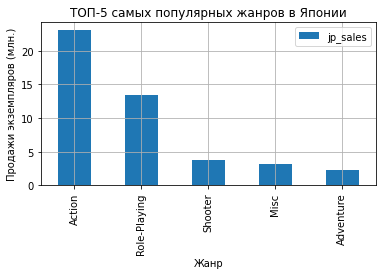

In [358]:
top_genre_jp = data_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_genre_jp= top_genre_jp.reset_index().rename_axis(None, axis=1)
display(top_genre_jp)
top_genre_eu = data_period.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

top_genre_jp.plot(x = 'genre', y = 'jp_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных жанров в Японии')
plt.xlabel('Жанр')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Топ по рейтингу с 2015г. в Японии:

,rating,jp_sales
0,неопределен,32.89
1,13+,7.70
2,6+,5.25
3,17+,4.29
4,0+,3.27


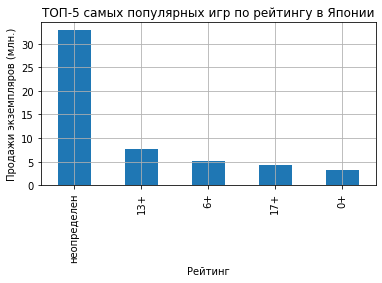

In [359]:
top_rating_jp = data_period.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_rating_jp= top_rating_jp.reset_index().rename_axis(None, axis=1)
display(top_rating_jp)
top_rating_jp = data_period.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head(5)
top_rating_jp.plot(x = 'rating', y = 'jp_sales', kind = 'bar', figsize=(6,3), grid=True, title = 'ТОП-5 самых популярных игр по рейтингу в Японии')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

###### Вывод: 
- Самые популярные игровые платформы в Японии это: Nintendo DS, PS, PS2, Nintendo SNES, Nintendo 3DS;
- Топ- 5 жанров в Японии : Role-Playing, action, sports, platform, misc;
По рейтингам видно, что больше всего продаж у игр с рейтингом "неопределен", на втором месте игры с рейтингом "6+" и на третьем месте игры с рейтингом "13+".

За последний год интерес у пользователя кардинально изменился:
- Топ Жанров: action, role-playing, adventure;
- Топ платформ: Nintendo 3DS, PS4, Nintendo Wii U;
- Топ рейтингов: "+6", "13+" и "17+".

Вывод по составлению портрета пользователя каждого региона:

Для прогноза будущих продаж лучше брать данные за последний год, так как технологии меняются быстрыми темпами, и вкусы людей также меняются. Соответственно, для 2017 года большую часть прибыли будут приносить игры жанра Shooter, для платформы PS4 и с рейтингом от 17 и выше. Также стоит обращать внимание на регион продаж игр, в Японии отличная ситуация с жанрами и рейтингом, так как культура координально отличается от Америки и Европы.
Также исследуя рейтинг, можно предположить, что рейтинг "неопределен"- возможно игры с определнными жестокими сценами, так как одним из популярных жанров является shooter. Будем сотавлять портрет для Европы и Америки вместе, а для Японии отдельно.

Для Европы и Америки:
У Пользователей популярными платформами являются PS4, Xbox One,PC а также Nintendo DS3. Популярные жанры:action, sports, shooter, а рейтинг игр:"17+", "13+", "неопределен".


Для Японии:
У Пользователей популярными платформами являются Nintendo 3DS, PS4, PSV. Популярные жанры:Action, Role-playing, Adventure. Рейтинг: "13+", "17+", "неопределен".

# Проверка гепотез

Сформулируем гепотезы:
    
Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ XB и PS одинаковые;
    
Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ XB и PS различаются.

In [360]:

data_xbox =data_period[data_period['platform'] == 'Xbox One']
data_pc = data_period[data_period['platform'] == 'PC']

xbox_1 = data_xbox['user_score']
pc_1 = data_pc['user_score']
alpha = .05 

results = st.ttest_ind(
xbox_1,
pc_1)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3258876032093114
Не получилось отвергнуть нулевую гипотезу


Выполним проверку гипотезы. Будем использовать метод ttest_ind:

In [361]:
genre_action_hyp = data_period[(data_period['genre']=='Action') & (data['year_of_release'])]['user_score']
genre_sports_hyp = data_period[(data_period['genre']=='Sports') & (data['year_of_release'])]['user_score']
alpha = .05

results = st.ttest_ind(genre_action_hyp.dropna(), genre_sports_hyp.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14229940215067705
Не получилось отвергнуть нулевую гипотезу


Вывод: Значение p-value равно 1%. Таким образом, отвергаем Нулевую гипотезу. То есть,скорее всего среднепользовательские рейтинги будут различаться

Сформулируем нулевые гипотезы:

Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports различаются.

Сохраним в переменных genre_action_hyp и genre_sports_hyp соответствующие данные с пользовательскими оценками:

Вывод: Получив p-value, мы отвергли Нулевую гипотезу. Таким образом, у нас практически нет вероятности получить одинакове средние рейнтинги по двум жанрам.

Вывод по проверке гипотез

Проверили гипотезы по ТЗ:

- Гипотеза: "Средние пользовательские рейтинги платформ Xbox one и PC одинаковые". Нулевую гипотезу не удалось опровергнуть.
- Гипотеза: "Средние пользовательские рейтинги жанров Action и Sports разные". Отвергаем нулевую гипотезу.

Общий вывод:

- Перед анализом данных, мы подготовили наши данные, привели к правильным данным столбцы, привели к нижнему регистру таблицы и сами названия колонок и привели к правильным типам данных необходимые столбцы.
- Пик выпуска игр для приставок приходится на период с1995-2008гг.Спад реализации игр с 2008г, возможно связан с выпуском мобильных игр.
- Топ-5 игровых платформ за весь период:PS2, Xbox 360, PS3,Nintendo WII, Nintendo DS.
- Средняя жизнь игровой платформы составляет 10 лет. Пик продаж наступает примерно через 5 лет после выхода приставки.
- Больше всего продаются игры на Sony Playstation и Xbox 360
-  У всех платформ наблюдается взаимосвязь между продажами и оценками критиков и пользователей.
- Заметнее всего корреляция между оценками критиков и продажами. Это значит для людей мнение критиков важнее мнения других пользователей.
После мы составили портреты пользователей каждого региона.
Для жителей Северной Америки и Европы:
- Популярные action, sports, shooter. 
- Популярные приставки : XBOX, PS2 и  Nintendo WII, также PS3 
- А по рейтингу игр люди предпочитают игры с рейтингами: "неопределен", "от 13 и выше" и "от 17 и выше".
Для жителей Японии:
- Популярные игровые приставки: Nintendo DS, PS, PS2. А 
- Популярные жанры игры : Role-playing, action и sports. 
- Рейтинг игр аналогичный Северной Америке и Европе.


Прогноз:
- Исходя из всех данных предполагаем, что лучше всего продавать игры для таких приставок как Sony Playstation (разных поколений) и Хbox. 
- Ориентироваться нужно на территориальное размещение пользователей, если культура координально отличается от европейской и американской, стоит внимательно ориентироваться на особенности региона.
- Жанр Shooter выбрать как наиболее подходящий для продаж, рейтинг соответсвующий "17+". Если учитывать данные критерии, то продажи предположительно будут выше.

